Credit goes to https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb for the steps to use graph_tool in Colab.

In [ ]:
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install gravis

In [2]:
from graph_tool.all import *

g = load_graph("HepPh_with_louvain_and_label.graphml")

In [3]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import numpy as np

date_cutoffs = []

curr_date = datetime.strptime("1995-06-01", "%Y-%m-%d").date()
while curr_date.strftime("%Y-%m-%d") < "2000-06-01":
    date_cutoffs.append(curr_date.strftime("%Y-%m-%d"))
    curr_date += relativedelta(months=+2)

In [7]:
import time
from collections import Counter
from tabulate import tabulate

class MyList:
    def __init__(self, arr):
        self.arr = arr

    def __add__(self,other_arr):
        if type(other_arr) == list:
            self.arr.extend(other_arr)
        if type(other_arr) == MyList:
            self.arr.extend(other_arr.arr)
        return self

    def __radd__(self,other_arr):
        if type(other_arr) == list:
            self.arr.extend(other_arr)
        if type(other_arr) == MyList:
            self.arr.extend(other_arr.arr)
        return self

def getModularity(G, parts_idx, edge_weights):
    return modularity(G, parts_idx, weight=edge_weights)

def moveNodes(G, parts_idx, edge_weights, vertex_degrees):
    count = 0

    community_tots = {}
    total_edges = 0
    for comm_idx,tot in zip(parts_idx.a, vertex_degrees.a):
        community_tots[comm_idx] = tot
        total_edges += tot
    total_edges = int(total_edges/2)

    while True:
        mod_old = getModularity(G, parts_idx, edge_weights)

        for v in G.iter_vertices():
            neighbour_communities = {parts_idx[v] : 0}

            for s, t, weight in G.iter_out_edges(v, eprops=[edge_weights]):
                if s is v and t is v:
                    continue
                if s is v:
                    if parts_idx[t] not in neighbour_communities:
                        neighbour_communities[parts_idx[t]] = weight
                    else:
                        neighbour_communities[parts_idx[t]] += weight
                elif t is v:
                    if parts_idx[s] not in neighbour_communities:
                        neighbour_communities[parts_idx[s]] = weight
                    else:
                        neighbour_communities[parts_idx[s]] += weight
            curr_max_dQ = 0

            curr_best_swap = parts_idx[v]

            k_v_own = neighbour_communities[parts_idx[v]]

            own_community_tot = community_tots[parts_idx[v]]

            for community, k_v_comm in neighbour_communities.items():
                if community == parts_idx[v]:
                    continue

                dQ = vertex_degrees[v]*(own_community_tot - vertex_degrees[v] - community_tots[community]) + 2*total_edges*(k_v_comm - k_v_own)

                if dQ > curr_max_dQ:
                    curr_max_dQ = dQ
                    curr_best_swap = community

            if curr_max_dQ > 0:
                community_tots[curr_best_swap] += vertex_degrees[v]
                community_tots[parts_idx[v]] -= vertex_degrees[v]

                parts_idx[v] = curr_best_swap

        count += 1
        mod_new = getModularity(G, parts_idx, edge_weights)
        # print(f"After moveNodes iteration {count}:", mod_new)
        if mod_new == mod_old:
            break
    return len(set(list(parts_idx)))

def Louvain(G):
    G_copy = G.copy()
    G_copy.set_directed(False)
    comps,hist = label_components(G_copy)
    assert(len(hist) == 1)

    master_partition = G_copy.new_vp("object")
    for idx,v in enumerate(G_copy.iter_vertices()):
        master_partition[v] = MyList([G_copy.vertex_index[idx]])

    num_partitions = G_copy.num_vertices()


    partition_idxs = G_copy.new_vp("int")
    for i in range(G_copy.num_vertices()):
        partition_idxs[i] = i

    curr_iteration = 0

    edge_weights = G_copy.new_ep("int")
    edge_weights.set_value(1)

    while True:
        vertex_degrees = G_copy.degree_property_map("total", weight=edge_weights)

        old_mod = getModularity(G_copy, partition_idxs, edge_weights)

        num_partitions = moveNodes(G_copy, partition_idxs, edge_weights, vertex_degrees)

        curr_iteration += 1

        new_mod = getModularity(G_copy, partition_idxs, edge_weights)

        print(f"After iteration {curr_iteration}", new_mod)

        if abs(old_mod - new_mod) < 0.0000001:
            break

        G_copy, partition_idxs, vcount, edge_weights, avp, aep = condensation_graph(G_copy, partition_idxs, avprops=[master_partition], eweight=edge_weights, self_loops=True)

        master_partition = avp[0]

    final_part_idxs = G.new_vp("int")
    for part_idx,part in enumerate(master_partition):
        for node in part.arr:
            final_part_idxs[node] = part_idx
    return final_part_idxs

After iteration 1 0.03991960610934157
After iteration 2 0.06401542013091471
After iteration 3 0.09413066994249546
After iteration 4 0.13646515337641824
After iteration 5 0.17109823568160468
After iteration 6 0.19532010895689814
After iteration 7 0.20381471946763832
After iteration 8 0.20504242237216652
After iteration 9 0.20504242237216652
After iteration 1 0.036759839589096996
After iteration 2 0.05942769772321874
After iteration 3 0.08726845692277042
After iteration 4 0.12444056574581813
After iteration 5 0.15545726460823067
After iteration 6 0.18468190132804196
After iteration 7 0.2100248899276506
After iteration 8 0.22561335339414088
After iteration 9 0.22637836125454747
After iteration 10 0.22637836125454747
After iteration 1 0.03526612157661515
After iteration 2 0.05727137133882706
After iteration 3 0.08161079686539914
After iteration 4 0.11458031801245225
After iteration 5 0.14424795407102542
After iteration 6 0.1718103411389723
After iteration 7 0.1968588905232475
After iterati

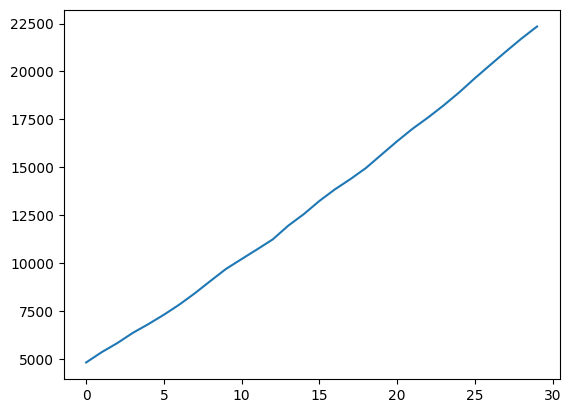

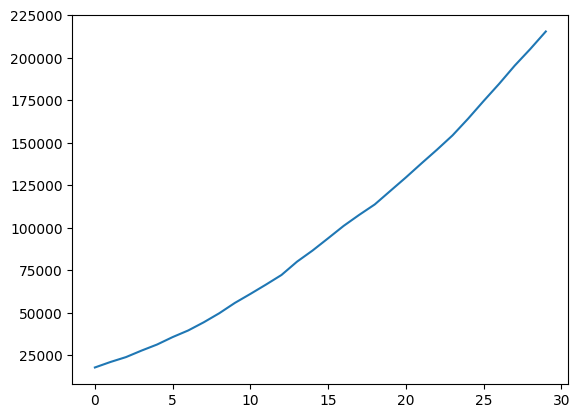

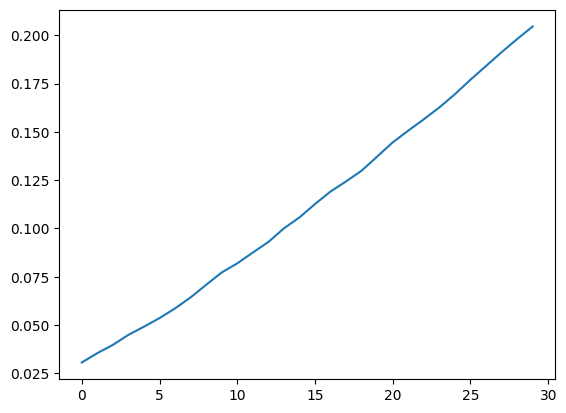

In [8]:
from matplotlib import pyplot
import pickle

num_node_plot = [[],[]]
num_edge_plot = [[],[]]
avg_cc_plot = [[],[]]
community_assignments = []

for slice_idx, date_cutoff in enumerate(date_cutoffs):
    u = GraphView(g, vfilt=lambda v: g.vp.date[v] < date_cutoff)
    u = extract_largest_component(u, directed=False)

    num_node_plot[0].append(slice_idx)
    num_node_plot[1].append(u.num_vertices())

    num_edge_plot[0].append(slice_idx)
    num_edge_plot[1].append(u.num_edges())

    avg_cc_plot[0].append(slice_idx)
    avg_cc_plot[1].append(np.mean(local_clustering(u).a))

    mask_arr = Louvain(u).ma

    louv_temp = []
    for val,masked in np.column_stack((mask_arr.data, mask_arr.mask)):
        if masked:
            louv_temp.append(-1)
        else:
            louv_temp.append(val)

    community_assignments.append(louv_temp)

pyplot.plot(num_node_plot[0], num_node_plot[1])
pyplot.show()
pyplot.plot(num_edge_plot[0], num_edge_plot[1])
pyplot.show()
pyplot.plot(avg_cc_plot[0], avg_cc_plot[1])
pyplot.show()

In [9]:
from google.colab import files
import pickle

with open("original_community_assignments_Louvain.dump", "wb") as fp:
    pickle.dump(community_assignments, fp)

files.download('original_community_assignments_Louvain.dump')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from collections import Counter

with open("original_community_assignments_Louvain.dump", "rb") as f:
    community_assignments = pickle.load(f)

# Let us relabel ALL community labels to be unique (except -1s as they are not community labels)
relabelled_comm_assgns = []
curr_max_label = 0
for comm_assgn in community_assignments:
    old_labels = Counter(comm_assgn).keys()
    old_to_new_map = {-1:-1}
    for label in old_labels:
        if label == -1:
            continue
        old_to_new_map[label] = curr_max_label
        curr_max_label += 1

    new_comm_assgn = [old_to_new_map[old_label] for old_label in comm_assgn]
    relabelled_comm_assgns.append(new_comm_assgn)
print(len(relabelled_comm_assgns))
for i in relabelled_comm_assgns:
    print(len(i), end=" ")

30
30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 

In [11]:
# Now get the community sets per time slice
per_slice_comm_sets = []
for relabelled_comm_assgn in relabelled_comm_assgns:
    comm_members = {}
    for node_idx, comm_label in enumerate(relabelled_comm_assgn):
        if comm_label in comm_members:
            comm_members[comm_label].add(node_idx)
        else:
            comm_members[comm_label] = {node_idx}

    comm_sets = [[comm_label, comm_members[comm_label], True] for comm_label in comm_members.keys()]
    # sort the communities by size (desc)
    per_slice_comm_sets.append(sorted(comm_sets, key=lambda x: len(x[1]), reverse=True))

print(len(per_slice_comm_sets))
for i in per_slice_comm_sets:
    print(len(i), end=" ")

30
18 14 19 19 17 23 18 19 19 21 19 18 15 18 19 16 16 18 17 17 17 17 15 17 16 15 17 19 19 15 

In [12]:
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py
def jaccard_similarity(set1, set2):
    return float(len(set1.intersection(set2))) / float(len(set1.union(set2)))

# Find similar communities across time slices
for time_slice_idx in range(1, len(per_slice_comm_sets)):
    # Check for each of this slices' communities
    for new_comm_idx,new_comm in enumerate(per_slice_comm_sets[time_slice_idx]):
        # skip if -1
        if new_comm[0] == -1:
            continue

        max_jacque = 0.0
        best_prev_label = -1
        best_prev_label_idx = -1
        for prev_comm_idx,prev_comm in enumerate(per_slice_comm_sets[time_slice_idx-1]):
            # skip if used already or -1
            if prev_comm[0] == -1 or prev_comm[2] == False:
                continue

            # calculate jaccard similarity
            jacque = jaccard_similarity(new_comm[1], prev_comm[1])
            if jacque > max_jacque:
                max_jacque = jacque
                best_prev_label = prev_comm[0]
                best_prev_label_idx = prev_comm_idx

        if best_prev_label != -1:
            # remove prev and set new label
            per_slice_comm_sets[time_slice_idx-1][best_prev_label_idx][2] = False
            per_slice_comm_sets[time_slice_idx][new_comm_idx][0] = per_slice_comm_sets[time_slice_idx-1][best_prev_label_idx][0]
        else:
            # create new label
            per_slice_comm_sets[time_slice_idx][new_comm_idx][0] = curr_max_label
            curr_max_label += 1

In [13]:
# Now we have the temporal communities
# Save and download them
with open("temporal_community_assignments_Louvain.dump", "wb") as fp:
    pickle.dump(per_slice_comm_sets, fp)

files.download('temporal_community_assignments_Louvain.dump')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of unique communities across slices: 178


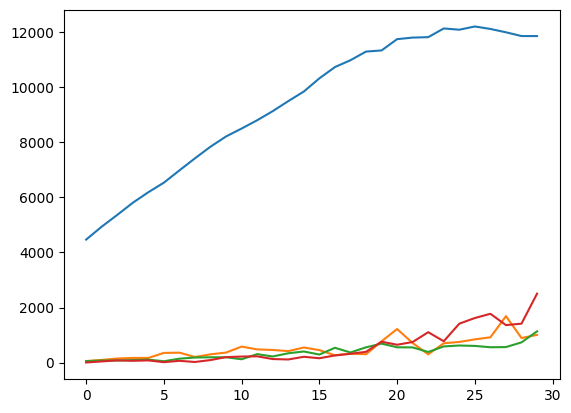

In [14]:
# Lets plot the size of the communities over time!
temporal_comm_size_data = {}
for time_slice_idx,per_slice_comm_set in enumerate(per_slice_comm_sets):
    for comm in per_slice_comm_set:
        if comm[0] == -1:
            continue
        if comm[0] in temporal_comm_size_data:
            temporal_comm_size_data[comm[0]][0].append(time_slice_idx)
            temporal_comm_size_data[comm[0]][1].append(len(comm[1]))
        else:
            temporal_comm_size_data[comm[0]] = [[time_slice_idx],[len(comm[1])]]

print("Number of unique communities across slices:",len(temporal_comm_size_data.keys()))
for comm_label in temporal_comm_size_data.keys():
    if len(temporal_comm_size_data[comm_label][0]) < 30:
        continue
    # print(temporal_comm_size_data[comm_label][0], temporal_comm_size_data[comm_label][1])
    pyplot.plot(temporal_comm_size_data[comm_label][0], temporal_comm_size_data[comm_label][1])
pyplot.show()